# Batsim Demo

Here is a simple example of how you can run batsim simple experiment and analyse the results.

If you already have Batsim and Batsched installed skip the Setup section.

#  Setup
First you need to install batsim and scheduler. We will use the scheduler reference implementation batsched.

We use the Nix package manager (available on Linux and MacOS) to do these installation.
See the [installation documentation](./doc/run_batsim.md) for more details.

## Install Nix

First, if you do not have Nix yet (what are you waiting for!), you need to install Nix but don't worry it is pretty straightforward:

In [ ]:
%%bash
curl https://nixos.org/nix/install | sh

## Install Batsim tools

In [ ]:
%%bash
. ~/nix-profiles/etc/profile.d/nix.sh
nix-env -f https://github.com/freuk/datamovepkgs/archive/master.tar.gz -i batsim
nix-env -f https://github.com/freuk/datamovepkgs/archive/master.tar.gz -i batsched
nix-env -f https://github.com/freuk/datamovepkgs/archive/master.tar.gz -i batexpe

Batsim is now available directly:

In [294]:
! batsim --version
! batsched --version
! robin --version

v2.0.0
v1.2.1
v1.0.0


## Launch this notebook

If you are viewing a non-interactive version of this notebook and you want to give it a try by yourself, you can setup the environment and run the notebook with these commands:
```sh
nix-shell https://github.com/freuk/datamovepkgs/archive/master.tar.gz \
    -A evalysNotebookEnv \
    --run jupyter-notebook Batsim_demo.ipynb
```

# Run the Simulation

Now that we have everything setup and ready let's run the simulation.

## Get the parameters

In order to run batsim you'll need a platfom definition and a workload.

First let's get those from the great internet:

In [ ]:
!wget -c https://gitlab.inria.fr/batsim/batsim/raw/master/platforms/energy_platform_homogeneous_no_net_128.xml
    
for seed in range(6):
    !wget -c https://gitlab.inria.fr/mmercier/bebida/raw/master/experiments/run_hpc_workload/workloads/workload_hpc_seed{seed}_jobs250.json

We will try to compare different policies implemented by Batsched:

In [269]:
policies = ["fcfs_fast", "easy_bf_fast", "easy_bf" ]

## Generate experiment description

To be able to run the scheduler and the simulator process with one command, Batsim need his faithful Robin!

Note that you can run the batsim command and the batsched command in two terminals by hand or putting one process in backgroud with `&`, with these commands:

```sh
export policy=fcfs_fast
export seed=2
batsim -p energy_platform_homogeneous_no_net_128.xml \
       -w workload_hpc_seed${seed}_jobs250.json -v quiet -e ${policy} &
batsched -v ${policy}
```

Robin was  but jupyter notebooks are not capable of running two process in parallel right now, so let's use Robin :)

First we generate yaml files 

In [273]:
%%bash -s "{" ".join(policies)}"
for policy in $1
do
for seed in $(seq 5)
do
cat <<EOF > expe_${policy}_${seed}.yaml  
batcmd: batsim -p energy_platform_homogeneous_no_net_128.xml -w workload_hpc_seed${seed}_jobs250.json -v quiet -e ${policy}_${seed}
output-dir: ${policy}_${seed}
schedcmd: batsched -v ${policy}
simulation-timeout: 30
ready-timeout: 5
success-timeout: 5
failure-timeout: 0
EOF
echo "# expe_${policy}_${seed}.yaml created!"
# cat expe_${policy}_${seed}.yaml
done
done

# expe_fcfs_fast_1.yaml created!
# expe_fcfs_fast_2.yaml created!
# expe_fcfs_fast_3.yaml created!
# expe_fcfs_fast_4.yaml created!
# expe_fcfs_fast_5.yaml created!
# expe_easy_bf_fast_1.yaml created!
# expe_easy_bf_fast_2.yaml created!
# expe_easy_bf_fast_3.yaml created!
# expe_easy_bf_fast_4.yaml created!
# expe_easy_bf_fast_5.yaml created!
# expe_easy_bf_1.yaml created!
# expe_easy_bf_2.yaml created!
# expe_easy_bf_3.yaml created!
# expe_easy_bf_4.yaml created!
# expe_easy_bf_5.yaml created!


## Do the actual simulation

In [281]:
for policy in policies:
    for seed in range(1, 6):
        !robin expe_{policy}_{seed}.yaml --quiet
print("Done!")

Done!


# Analysis

Let's now compare or two scheduling policies with Evalys apython library that provides analysis and visualisation tools for the Batsiml output (and traces transofmation utils...).

## Metrics comparison

There is several metrics that are calculated by Batsim on the fly during the simulation, so you don't have to do it by yourself afterwards. These metrics are stored in a CSV file called `${prefix}_schedule.csv`.
 
Fist, lets load these files to see some metrics:

In [282]:
import pandas

metrics = pandas.DataFrame()
for policy in policies:
    for seed in range(1, 6):
        df = pandas.read_csv("{}_{}_schedule.csv".format(policy, seed))
        df = df.assign(policy = policy)
        df = df.assign(workload = seed)
        metrics = metrics.append(df, ignore_index=True)

metrics

batsim_version  consumed_joules      makespan  max_slowdown  \
0          v2.0.0              0.0  11304.243341     23.744978   
1          v2.0.0              0.0  11216.327828     23.591373   
2          v2.0.0              0.0  14234.577563     55.237706   
3          v2.0.0              0.0  11945.364187     19.775458   
4          v2.0.0              0.0  11300.417491     14.396294   
5          v2.0.0              0.0  11412.099563     22.470176   
6          v2.0.0              0.0  11146.306618     23.496010   
7          v2.0.0              0.0  15062.771125     66.484001   
8          v2.0.0              0.0  11945.364187     30.864080   
9          v2.0.0              0.0  11275.057491     14.561256   
10         v2.0.0              0.0  11187.138350     25.288731   
11         v2.0.0              0.0  10931.354016     22.773245   
12         v2.0.0              0.0  12528.305072     34.263482   
13         v2.0.0              0.0  11945.364187     11.677113   
14         v2.0.0              0.0  11275.057491     15.633719   

    max_turnaround_time  max_waiting_time  mean_slowdown  \
0           2611.375499       1806.549952       4.977482   
1           3583.537694       2143.047694       5.493117   
2           5727.658447       4281.628447      13.791670   
3           3047.891420       1853.024361       3.424947   
4           2305.348799       1059.938490       2.555885   
5           3075.711720       2205.948891       2.003687   
6           3608.676484       2168.186484       4.577121   
7           6555.852009       5150.971525       6.349471   
8           3703.942420       2349.108551       1.832767   
9           2293.706386       1248.268921       2.241201   
10          2772.090507       1910.551545       1.797703   
11          3571.783883       2131.293883       3.635228   
12          4021.385956       3395.774673       2.400366   
13          2829.650657       1438.310766       1.755261   
14          2378.066386       1151.088374       1.987339   

    mean_turnaround_time  mean_waiting_time  nb_computing_machines    ...     \
0             715.667108         514.423988                    128    ...      
1             834.765552         626.573792                    128    ...      
2            1945.343811        1746.187411                    128    ...      
3             522.627279         326.302719                    128    ...      
4             422.254437         220.007557                    128    ...      
5             369.851450         168.608330                    128    ...      
6             708.063669         499.871909                    128    ...      
7            1010.010380         810.853980                    128    ...      
8             332.739486         136.414926                    128    ...      
9             375.576478         173.329598                    128    ...      
10            315.138336         113.895216                    128    ...      
11            591.942392         383.750632                    128    ...      
12            437.626596         238.470196                    128    ...      
13            310.942599         114.618039                    128    ...      
14            343.137216         140.890336                    128    ...      

    scheduling_time  simulation_time  success_rate  time_computing  \
0          0.065566         0.130932           1.0       969575.04   
1          0.057733         0.116672           1.0      1027489.32   
2          0.053204         0.109843           1.0      1063940.24   
3          0.060541         0.123717           1.0       997568.08   
4          0.059935         0.119923           1.0       892692.44   
5          0.086838         0.162024           1.0       969575.04   
6          0.057589         0.117530           1.0      1027489.32   
7          0.060473         0.121903           1.0      1063940.24   
8          0.062627         0.127109           1.0       997568.08   
9   

You can see that there is a lot of information here, from the batsim version to schedulting, power and usage metrics.
We also inject the workload seed number and the policy used.

You can get the list of all the available informations with:

In [262]:
metrics.columns

Index(['batsim_version', 'consumed_joules', 'makespan', 'max_slowdown',
       'max_turnaround_time', 'max_waiting_time', 'mean_slowdown',
       'mean_turnaround_time', 'mean_waiting_time', 'nb_computing_machines',
       'nb_grouped_switches', 'nb_jobs', 'nb_jobs_finished', 'nb_jobs_killed',
       'nb_jobs_success', 'nb_machine_switches', 'scheduling_time',
       'simulation_time', 'success_rate', 'time_computing', 'time_idle',
       'time_sleeping', 'time_switching_off', 'time_switching_on', 'policy',
       'workload'],
      dtype='object')

Now let's compare the two policies. on our different workloads

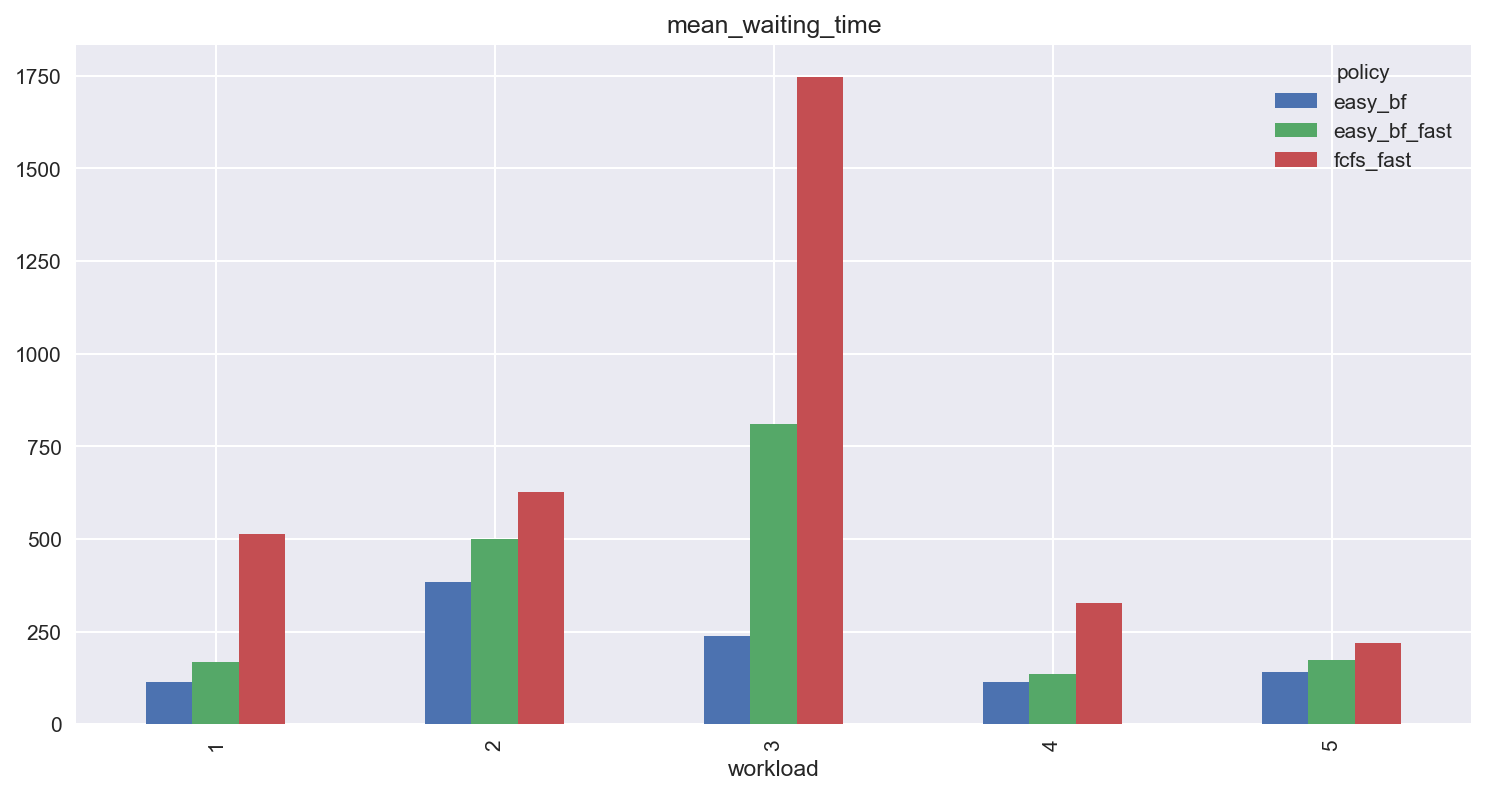

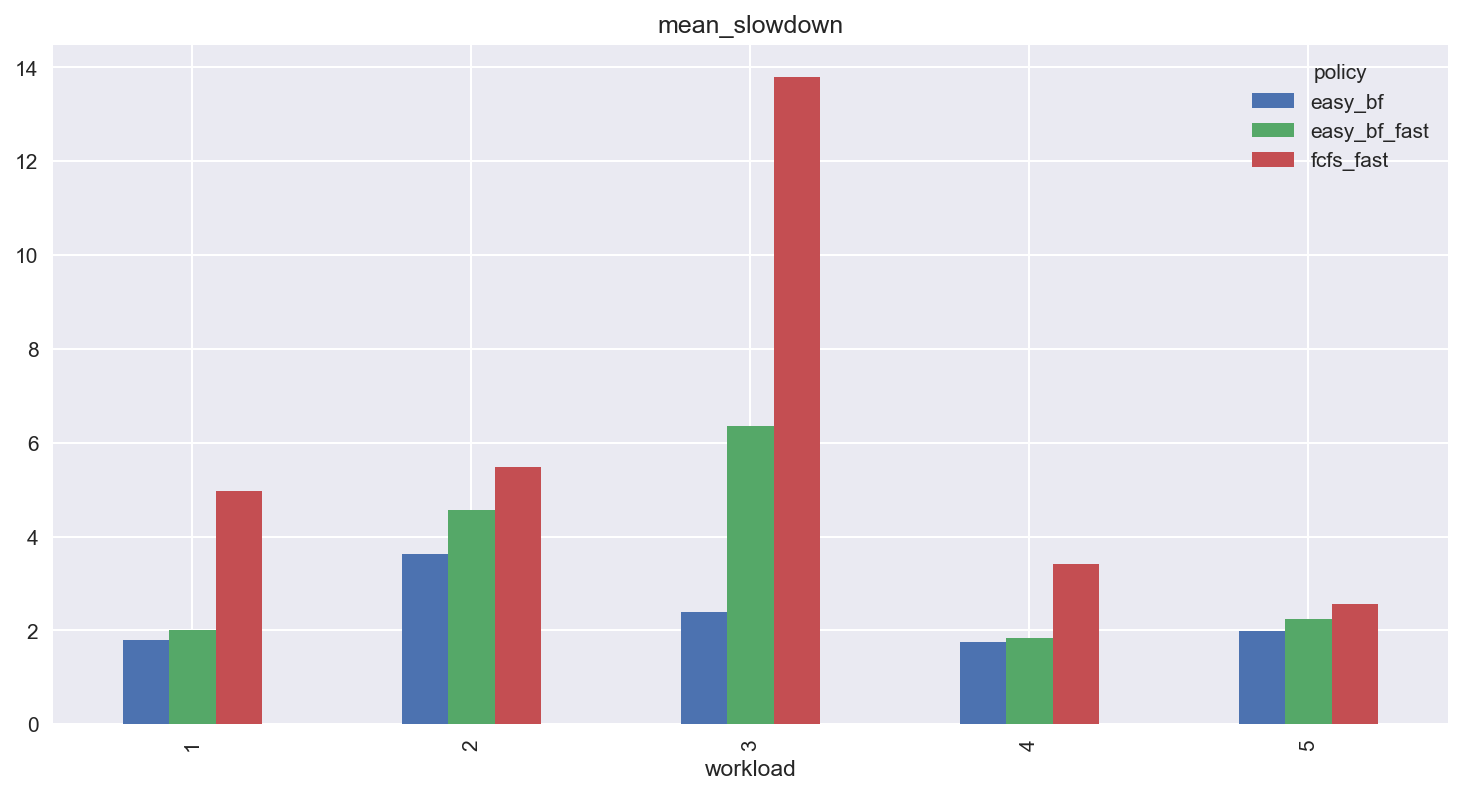

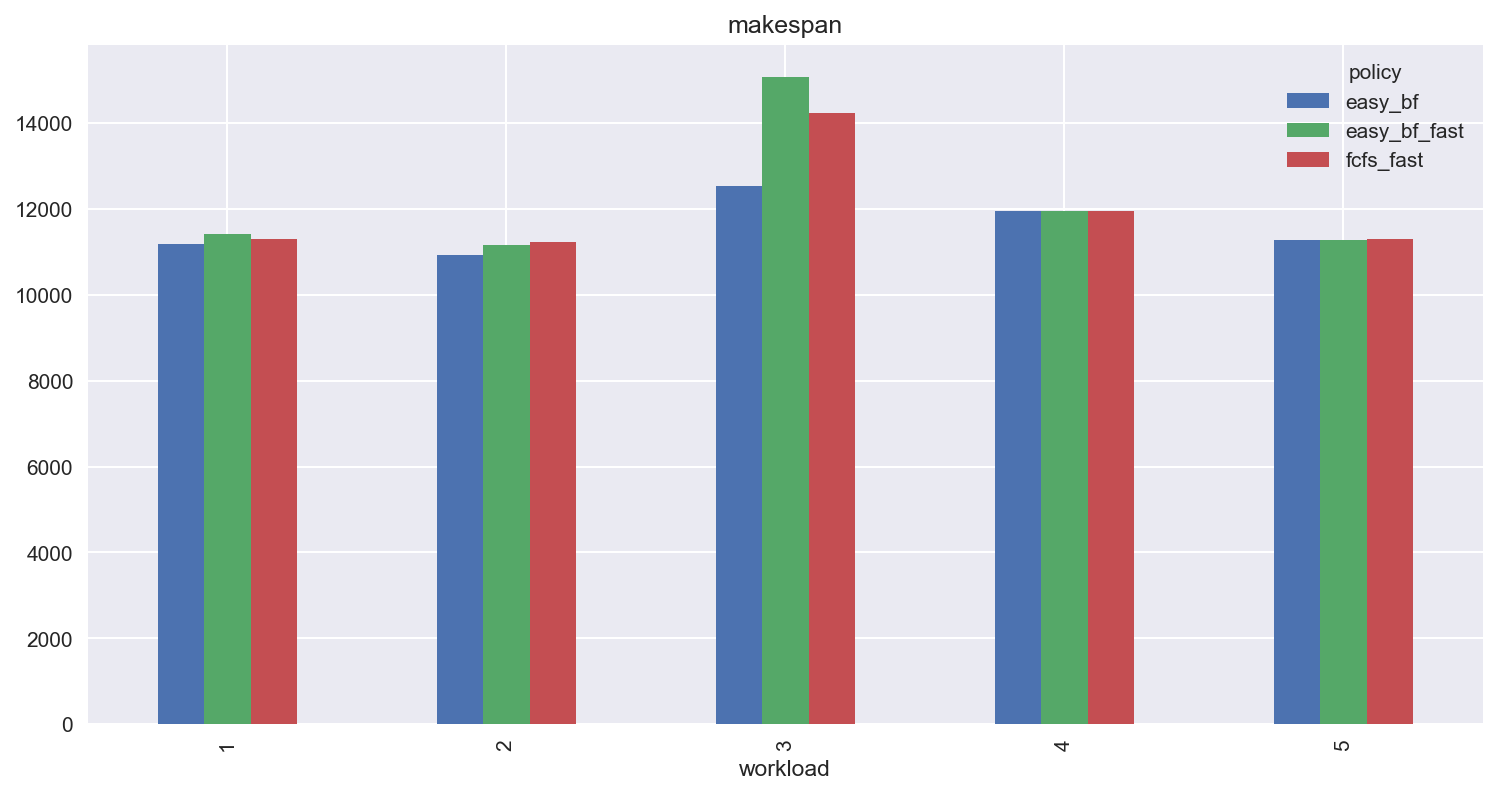

In [280]:
# Get bigger and nicer graph
matplotlib.rcParams['figure.figsize'] = 12,6
matplotlib.rcParams['figure.dpi']= 150

for metric in ["mean_waiting_time", "mean_slowdown", "makespan"]: 
    metrics.groupby(["workload","policy"])[metric].mean().unstack().plot.bar(title=metric)


As expected, Easy backfilling is much better in term of waiting time and slowdown. But, it is interesting to see that the makespan is not so much impacted by the policy.

## Detailed visualization

In the Batsim ecosystem live Evalys. Evalys is a python library that facilitate batsim (and swf) trace loading, processing, and visualization. Let's import it and have a detailed look at one of the traces, for example the workload 3 that seems to be an outlier.

In [286]:
%matplotlib inline
from evalys.jobset import JobSet
import matplotlib

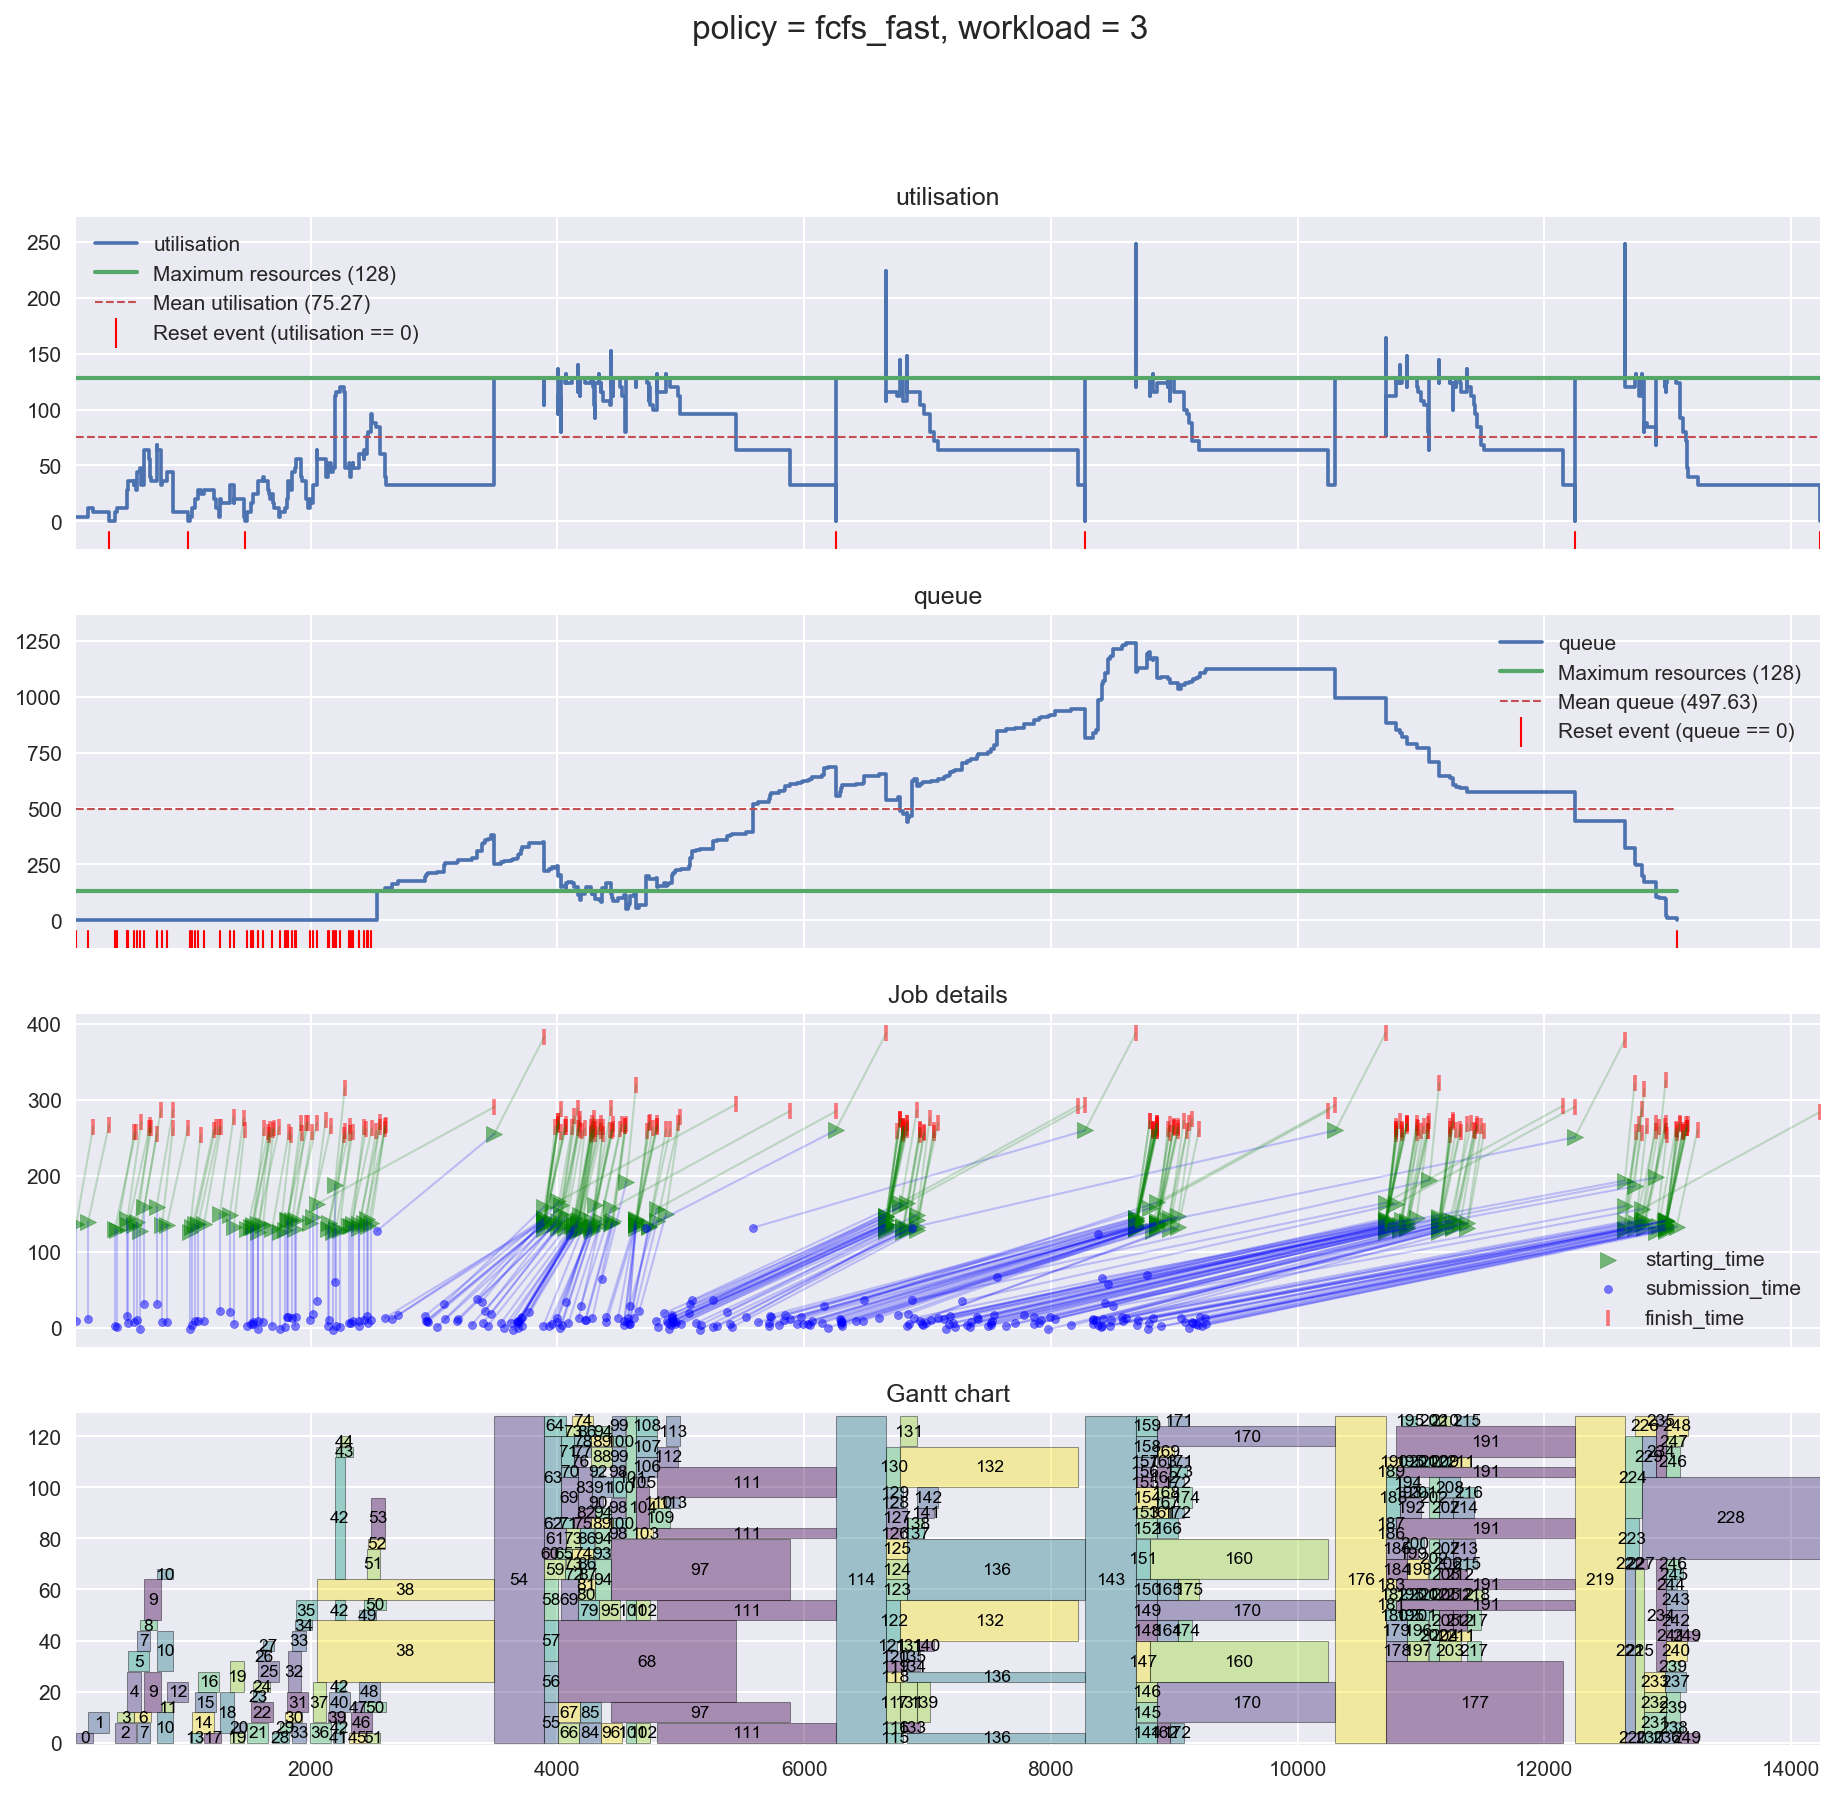

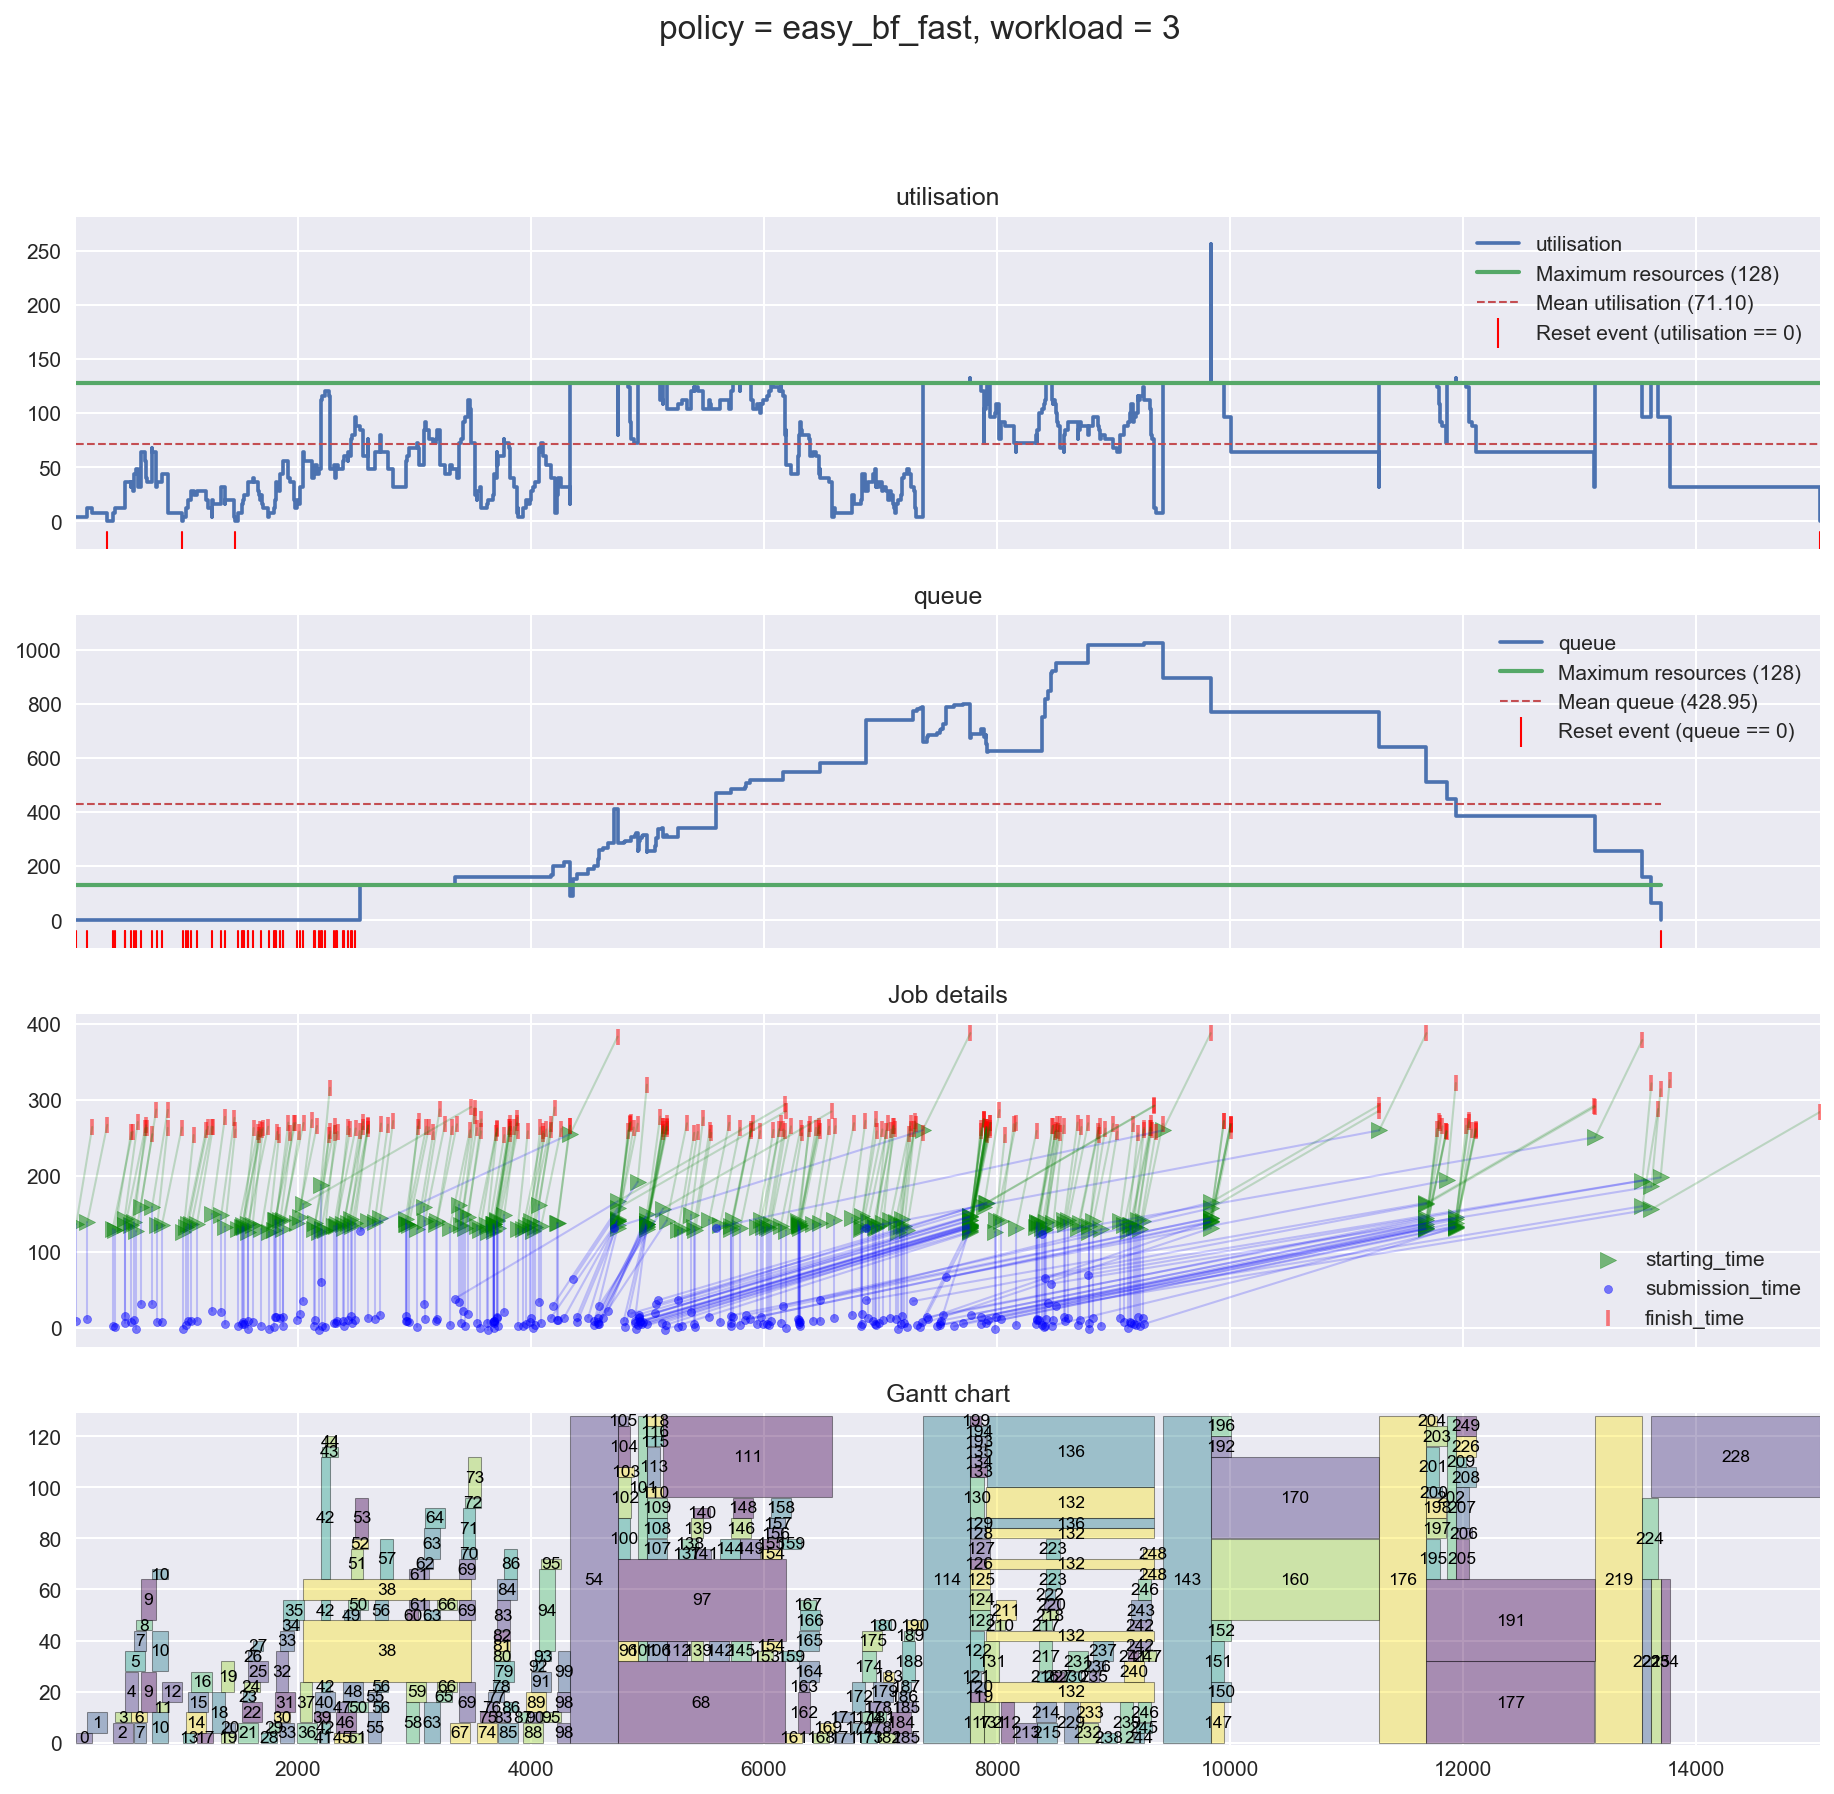

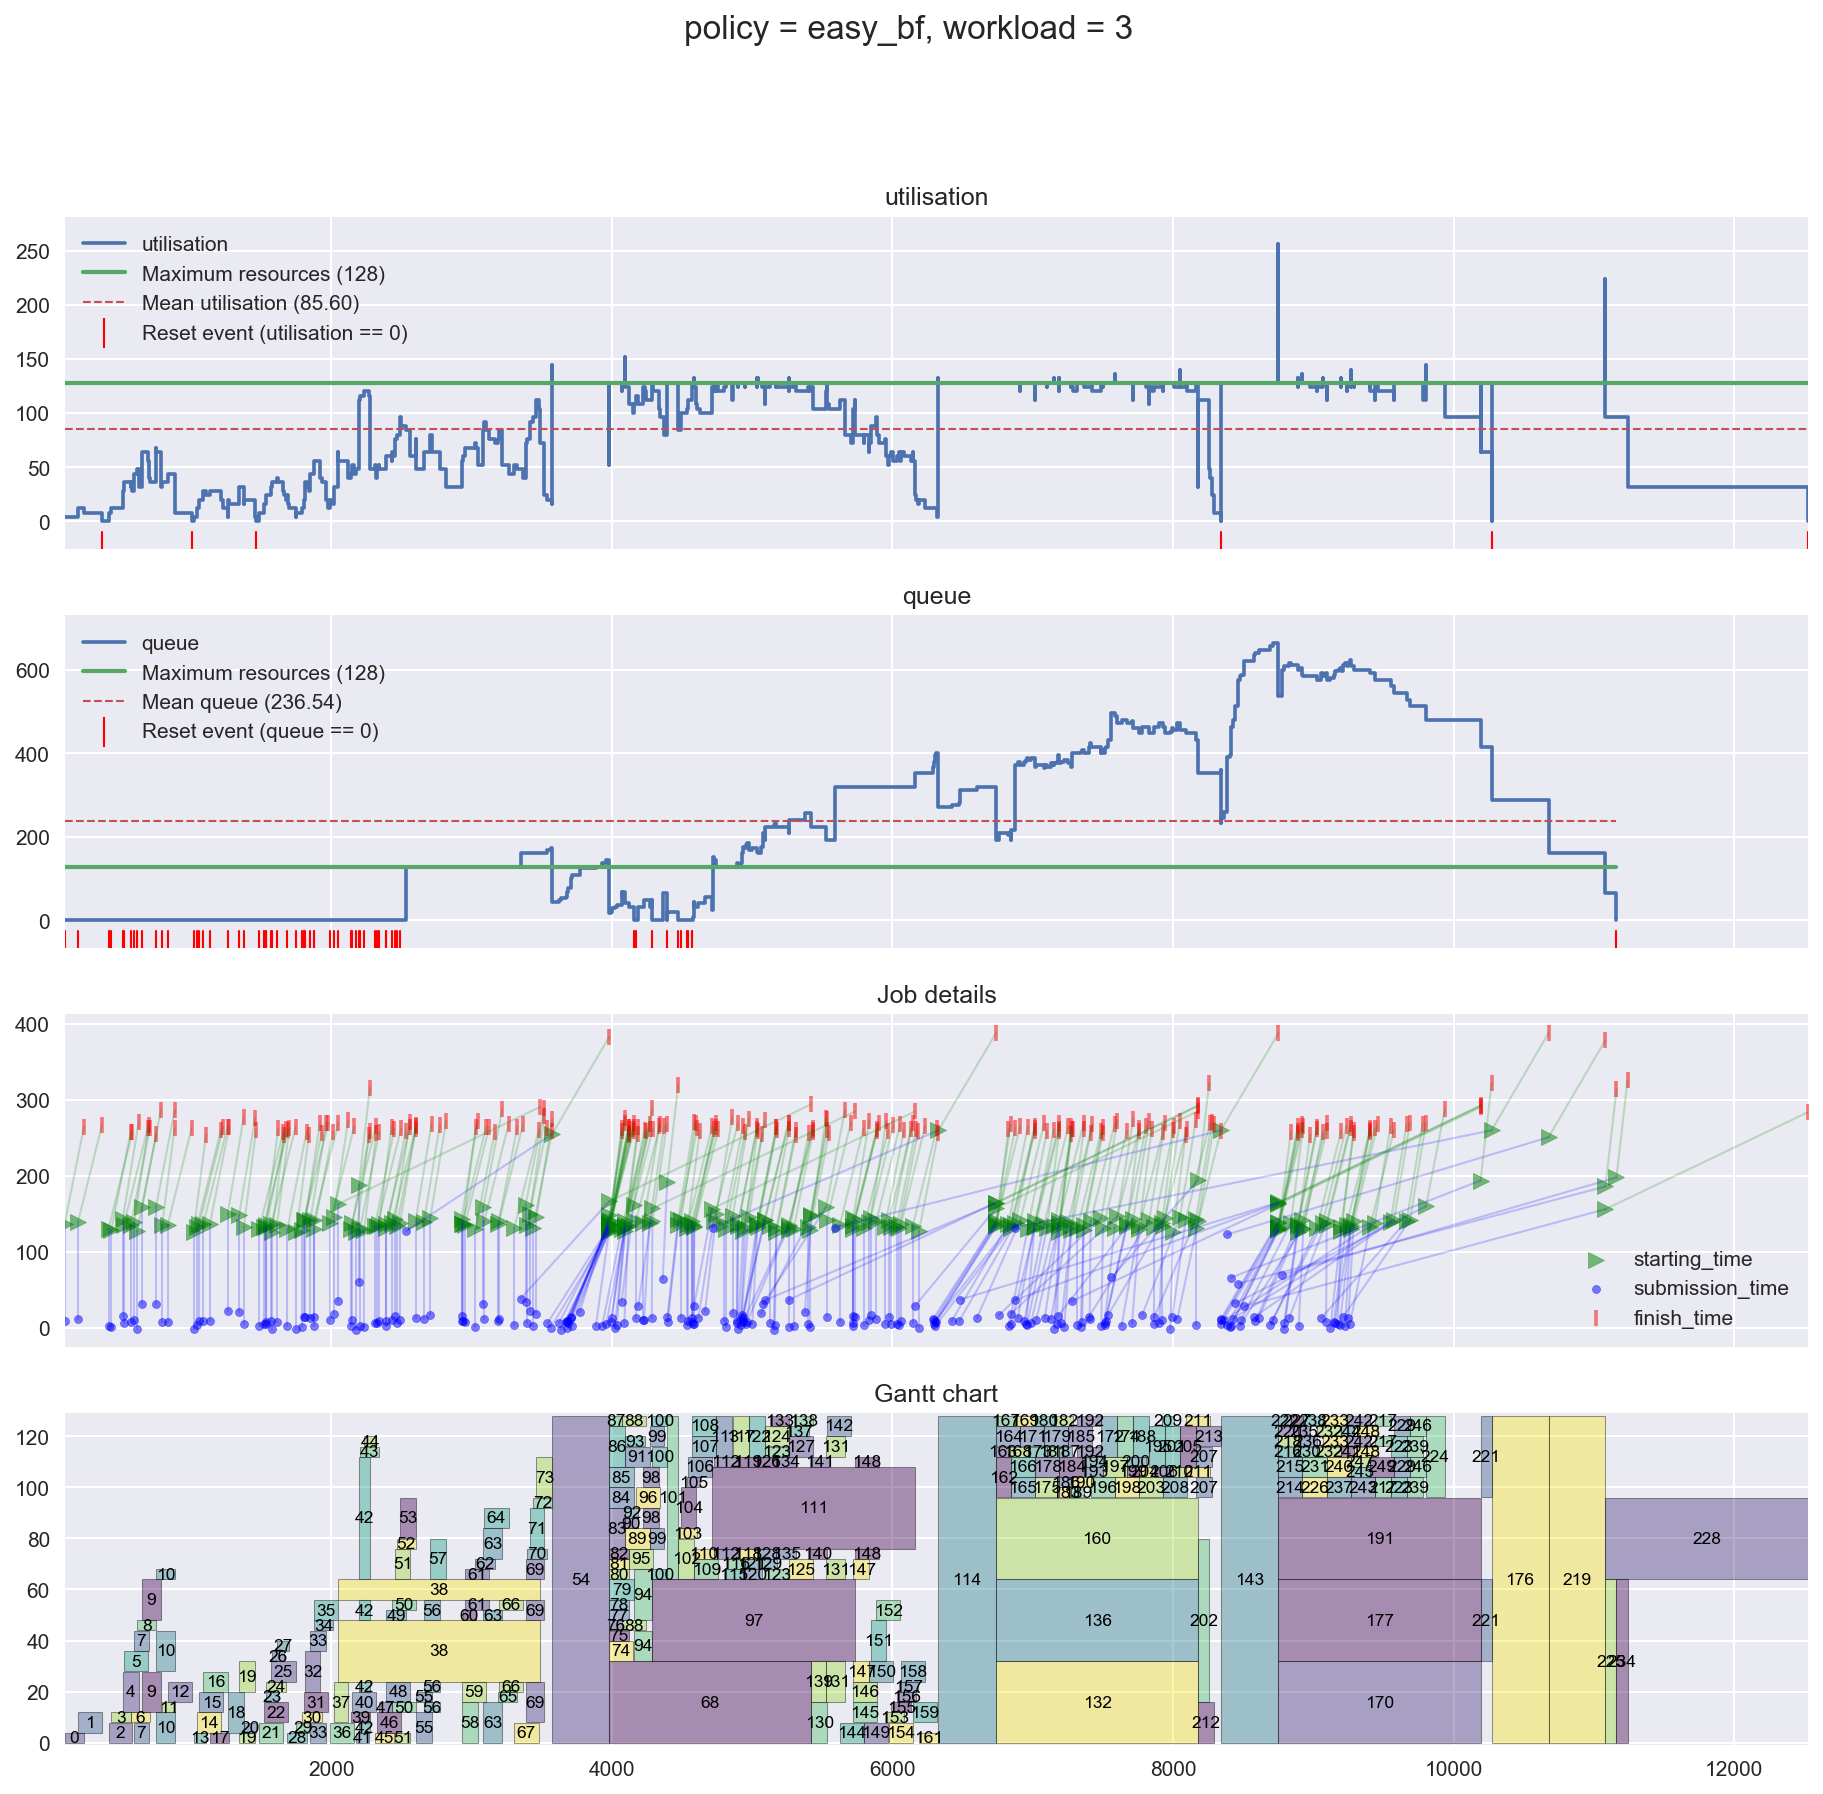

In [290]:
# Get bigger and nicer graph
matplotlib.rcParams['figure.figsize'] = 15, 13.5
matplotlib.rcParams['figure.dpi']= 150

# Let's explore seed 3 for all policies
seed = 3

js = {}
for policy in policies:
    js[policy] = JobSet.from_csv("./{}_{}_jobs.csv".format(policy, seed))
    js[policy].plot(with_details=True, title="policy = {}, workload = {}".format(policy, seed))

### Details visualization explained

Those 4 graphs deserved a small explaination. All of them share the same X axis, which is the time in seconds. The Y axis of all those graph is a number of resources, here a machine (a.k.a. compute node).

#### Utilisation

This graph shows the number of resources used by a job over time. with the green line beeing the maximum number of resources. Note that sometimes the utilisation goes upper the green line but it is just a visualization artefact du to events seen as simultaneous due to rounding.

#### Queue

The queue graph is the sum of all the resources requested by all the job in the queue over time. It represents the load of the cluster.

#### Job Details

This visualization (based on an original idea of David Glesser) is the one of the more interesting, but it needs some explaination to be understandable. Each job is represented by 3 elements join by lines. The first element is a blue dot that correspond to the submission time, the green triangle is the starting time and red bar the finish time. Those 3 element are not align because it is then very are to read because superposition of elements. That's why, each elements are seperated by the total number of resources (here 128) and they are all transated by the number of requested resources. It means that the bigger the job is in number of resources, the upper the 3 elements are translated.

It worth to note that we can observe job's waiting time by observing their blue lines verticality: if a job don't wait, his blue line is vertical and the more a job is waiting the more the blue line became horizontal.

The same overservation can be done for the jobs runtime and the green line.

#### Gantt chartt

This visualization is showing where and when each jobs has run during the simulation. It has to be correlated with the topology, with a mapping between nodes IDs and nodes position on the topology to fully understand allocation policies. 



## Detailed comparison

Ok, now that we have seen what's happening in details we can compare the two detailed view with each other to be able to do a fine grain comparison of policies choices.

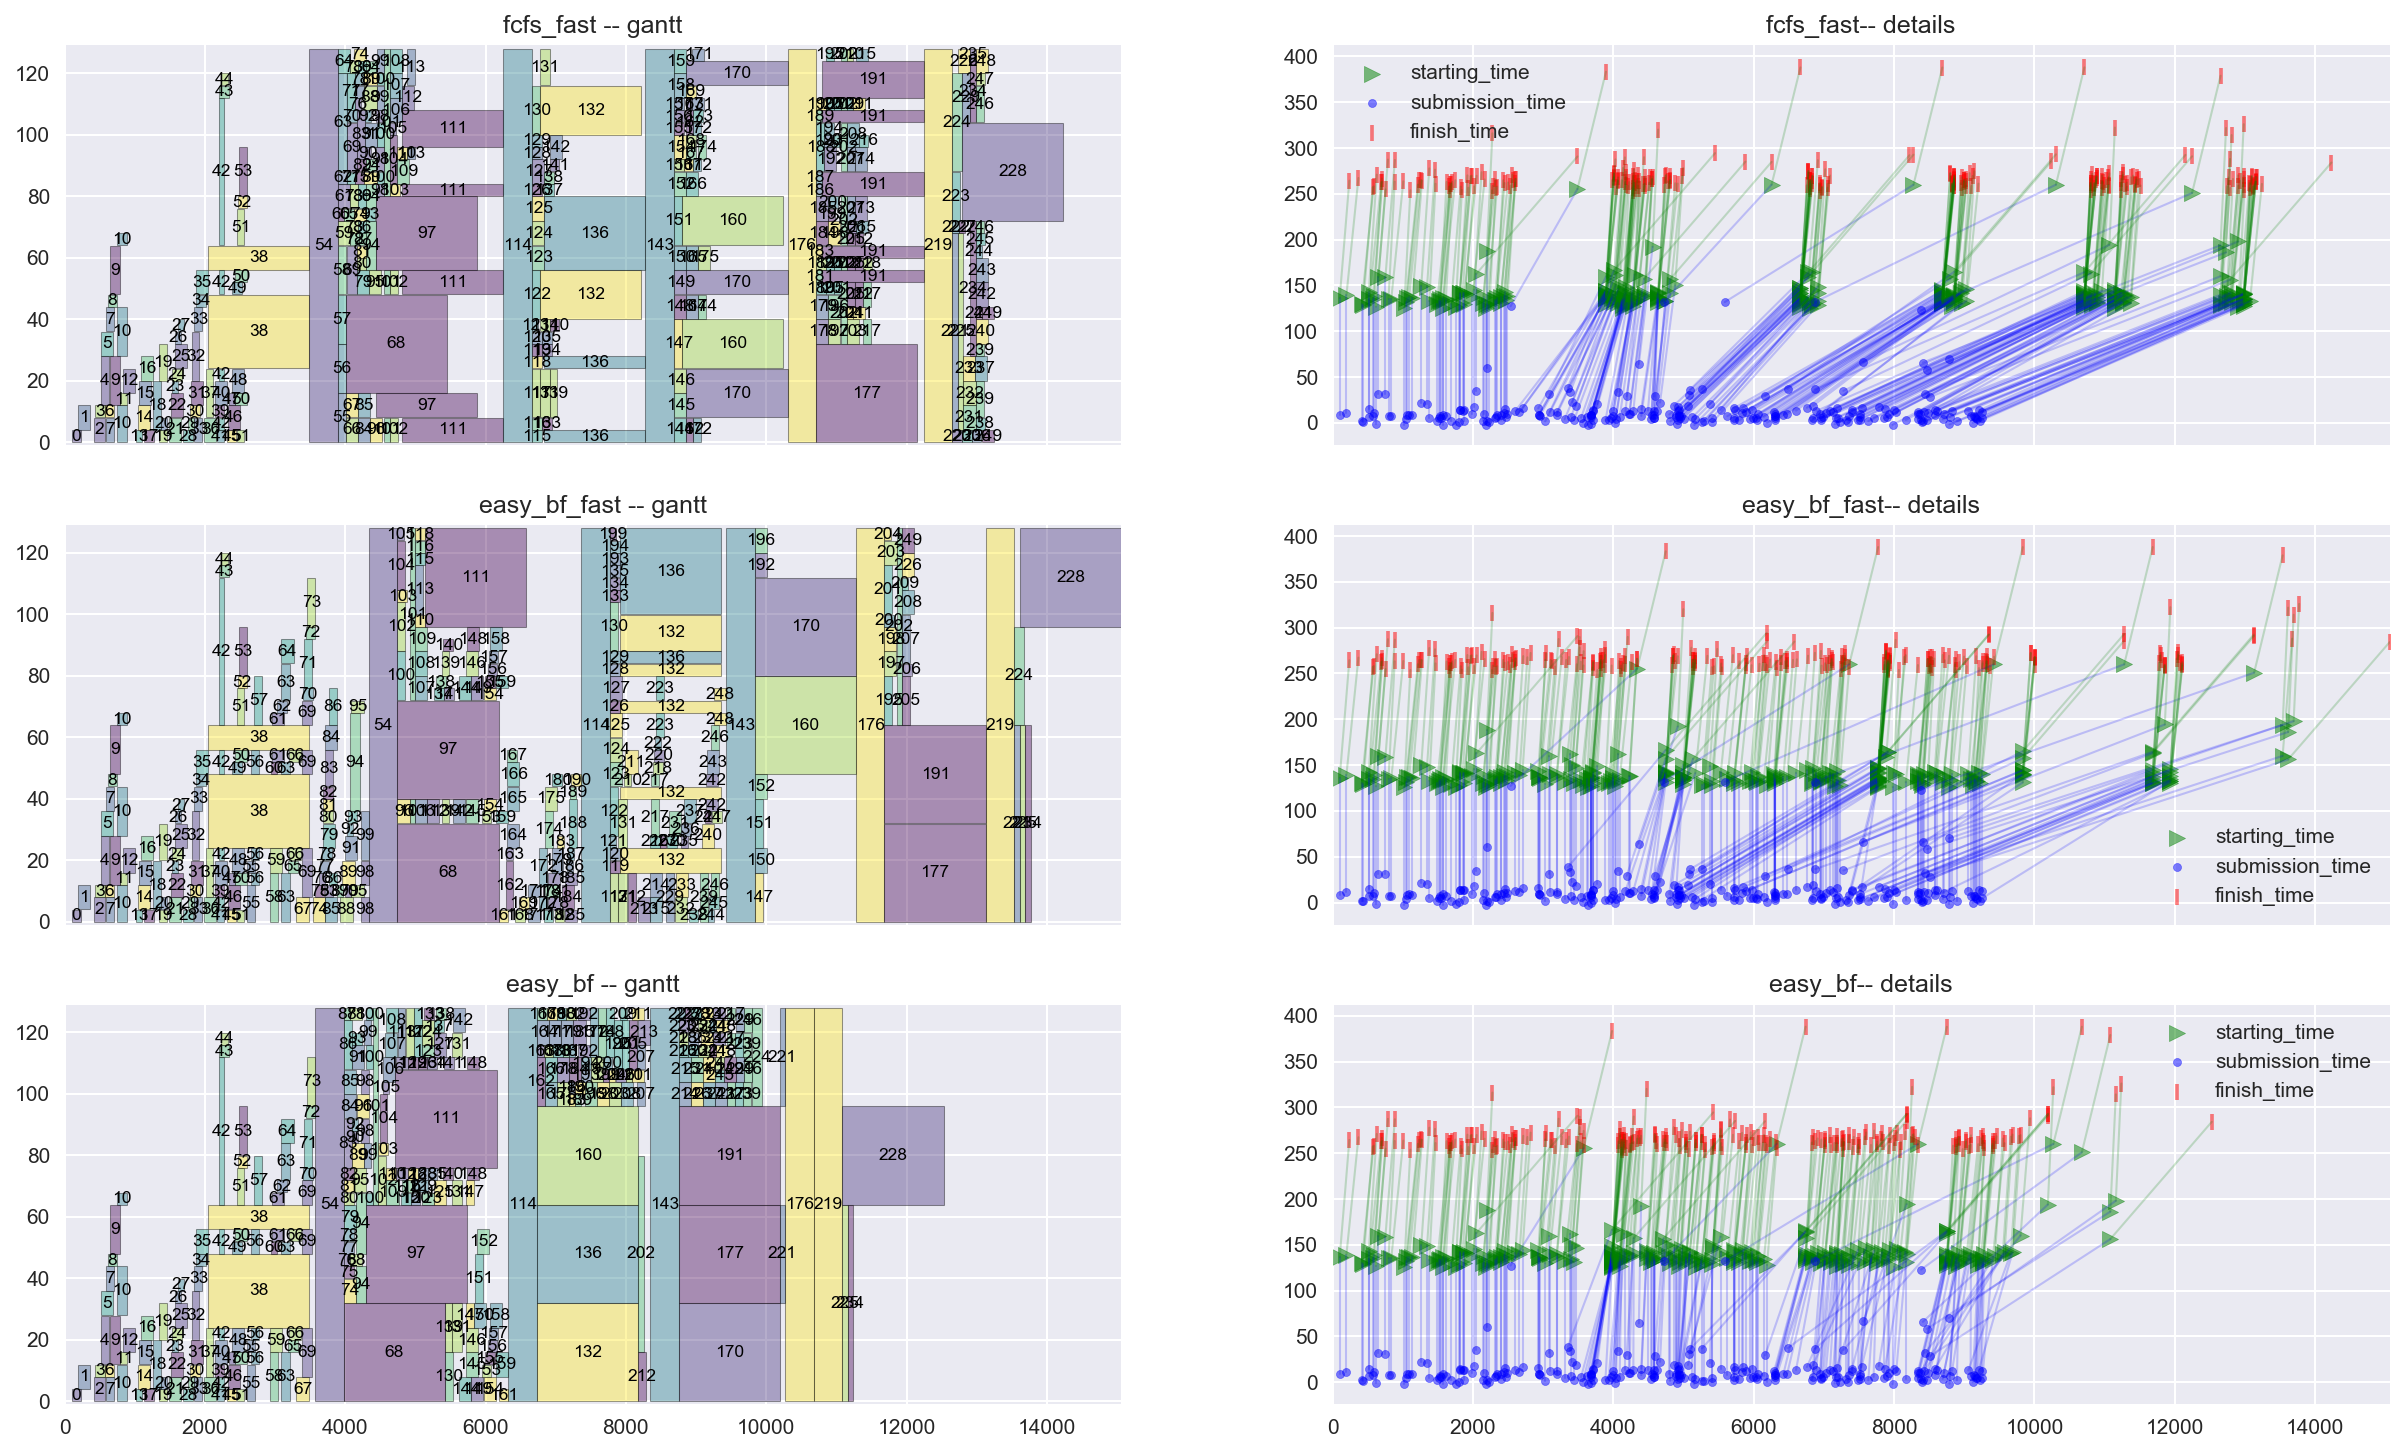

In [293]:
import matplotlib.pyplot as plt
from evalys import visu

matplotlib.rcParams['figure.figsize'] = 20, 12
matplotlib.rcParams['figure.dpi']= 150

fig, axes = plt.subplots(nrows=len(policies), ncols=2, sharex=True)

for i, policy in enumerate(policies):
    visu.plot_gantt(js[policy], ax=axes[i][0], title=policy + " -- gantt")
    visu.plot_job_details(js[policy].df, ax=axes[i][1], size=128, title=policy + "-- details")

# Get max values of all graphs to set the x limit properly
[axe.set_xlim([0, max(max(js_easy.df.finish_time), max(js_fcfs.df.finish_time))]) for sublist in axes for axe in sublist]
plt.savefig("easy_fcfs_comparision_details.pdf")

## Analysis conclusion

With this compared visualization we can easily see that the `easy_bf` policy has a much more efficient backfilling policy than `easy_bf_fast`, even if `easy_bf_fast` is better than the `fcfs` baseline in waiting time but not in makespan.

# Demo Conclusion

With this notebook you have a full example of what can be achieve with Batsim and all it's ecosystem: Batsched for baseline policies comparison, Robin to help you run a lot of experiments, and of course Evalys that helps you to understand the outputs of your experiments.